# Expression Cloning

In [183]:
import igl
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter
from scipy.sparse import  diags
from scipy.sparse.linalg import spsolve

In [404]:
def get_vertex_to_face_map(V, F):
    """
    For each vertex, returns a list of face indices it belongs to.

    Args:
        V (np.ndarray): Vertices array of shape (n, 3)
        F (np.ndarray): Faces array of shape (m, 3)

    Returns:
        vertex_face_map (list of lists): vertex_face_map[i] contains the list of face indices that vertex i belongs to
    """
    num_vertices = V.shape[0]
    vertex_face_map = [[] for _ in range(num_vertices)]

    for face_idx, face in enumerate(F):
        for vertex_idx in face:
            vertex_face_map[vertex_idx].append(face_idx)

    return vertex_face_map

def get_TBN_foreach_vertex(V, F):
    """
    Get TBN matrix for each vertex

    Args:
        V (np.ndarray): vertices (N, 3)
        F (np.ndarray): faces / trianlges (M, 3)

    Returns:
        np.ndarray: matrix (N, 3, 3)
        [
            [Tx, Ty, Tz],
            [Bx, By, Bz],
            [Nx, Ny, Nz],
        ]
    """
    Vn = igl.per_vertex_normals(V, F)
    
    al = igl.adjacency_list(F) # all neighbors
    nb = [nbrs[0] for nbrs in al] # select one
    
    Vt_nb = V[nb] - V
    Vt_nb = Vt_nb/np.linalg.norm(Vt_nb, axis=1)[:,None]

    # project
    _Vt = np.sum(Vt_nb * Vn, axis=1, keepdims=True)
        
    Vt = Vt_nb - (_Vt * Vn)
    Vt = Vt/np.linalg.norm(Vt, axis=1, keepdims=True)
    
    Vb = np.cross(Vn, Vt)
    Vb = Vb/np.linalg.norm(Vb, axis=1, keepdims=True)
    
    return np.concatenate([
        Vt[:,None], 
        Vb[:,None],
        Vn[:,None], 
    ], axis=1)

def rescale(V1 ,V2):
    """rescale V1 to V2"""
    V1mean = (V1.max(0)+V1.min(0))*0.5
    V2mean = (V2.max(0)+V2.min(0))*0.5
    V = (V1-V1mean)/max(V1.max(0)-V1.min(0)) * max(V2.max(0)-V2.min(0)) + V2mean
    return V

def get_TriangleArea_foreach_vertex(V,F):
    """
    Returns (V,)
    """
    DArea = igl.doublearea(V, F) * 0.5
    print(DArea.shape)

    V2F = get_vertex_to_face_map(V,F)
    VArea = []
    for v2f in V2F:
        VArea.append(np.sum(DArea[v2f])/len(v2f))
    VArea = np.array(VArea)
    return VArea

def get_scale_foreach_vertex(V,F):
    """
    Returns (V, 3)
    """
    # Vxyz = []
    # for vf in V[F]: # F, 3, 3
    #     Vxyz.append(vf.max(0)-vf.min(0))
    # Vxyz = np.array(Vxyz)
    
    V2F = get_vertex_to_face_map(V,F)
    Vscale = []
    for v2f in V2F:
        Vscale.append(np.std(V[F[v2f]].reshape(-1,3), axis=0))
    Vscale = np.array(Vscale)
    return Vscale

def get_scale_foreach_triangle(Vsrc, Vdef, Fsrc):
    """
    get scale ratio of DeformedSourceModelLocalBoudingBox / SourceModelLocalBoudingBox
    Returns (V, 3, 3)
    """
    S_matrices = np.zeros((Vsrc.shape[0], 3))

    all_nbh = igl.adjacency_list(Fsrc) # all neighbors for each vertex    
    for v_idx, nbh in enumerate(all_nbh):

        # get positions in both source and deformed meshes
        local_src = Vsrc[nbh]
        local_def = Vdef[nbh]

        # bounding box: max - min
        bbox_src = np.max(local_src, axis=0) - np.min(local_src, axis=0)
        bbox_def = np.max(local_def, axis=0) - np.min(local_def, axis=0)

        # prevent divide by zero
        bbox_src[bbox_src == 0] = 1e-8

        scale = bbox_def / bbox_src  # (3,)
        S_matrices[v_idx] = scale

    return S_matrices

def smooth(vert, lap, loop=1, t=0.01):
    D_Inv = diags(1 / lap.diagonal())
    _lap = D_Inv @ lap
    
    # a = 1-t
    I_L = scipy.sparse.identity(lap.shape[0]) - _lap*t
    # I_L = (I_L*t).power(loop)
    for i in range(loop):
        I_L = I_L.T @ I_L
    
    vert = I_L @ vert
    return vert

def taubin_smooth(vert, lap, values, loop=2, m=0.01, l=0.01):
    D_Inv = diags(1 / lap.diagonal())
    _lap = D_Inv @ lap
    
    I_L = scipy.sparse.identity(lap.shape[0]) - _lap*l
    I_M = scipy.sparse.identity(lap.shape[0]) - _lap*m
    
    I_L = I_L @ I_M
    for i in range(loop-1):
        I_L = I_L @ I_L
    
    values = I_L @ values
    return values

def mesh_smooth(V, F, values, tau=0.001):

    # Mesh smoothing with libigl
    l = igl.cotmatrix(V, F)  # laplace-beltrami operator in libigl
    m = igl.massmatrix(V, F, igl.MASSMATRIX_TYPE_BARYCENTRIC) # mass matrix in libigl
    s = m - tau * l
    return spsolve(s, m @ values)

def random_rotation_matrix(randgen=None):
    """
    Borrowed from https://github.com/nmwsharp/diffusion-net/blob/master/src/diffusion_net/utils.py
    
    Creates a random rotation matrix.
    randgen: if given, a np.random.RandomState instance used for random numbers (for reproducibility)
    """
    # adapted from http://www.realtimerendering.com/resources/GraphicsGems/gemsiii/rand_rotation.c
    
    if randgen is None:
        randgen = np.random.RandomState()
        
    theta, phi, z = tuple(randgen.rand(3).tolist())
    
    theta = theta * 2.0*np.pi  # Rotation about the pole (Z).
    phi = phi * 2.0*np.pi  # For direction of pole deflection.
    z = z * 2.0 # For magnitude of pole deflection.
    
    # Compute a vector V used for distributing points over the sphere
    # via the reflection I - V Transpose(V).  This formulation of V
    # will guarantee that if x[1] and x[2] are uniformly distributed,
    # the reflected points will be uniform on the sphere.  Note that V
    # has length sqrt(2) to eliminate the 2 in the Householder matrix.
    
    r = np.sqrt(z)
    Vx, Vy, Vz = V = (
        np.sin(phi) * r,
        np.cos(phi) * r,
        np.sqrt(2.0 - z)
        )
    
    st = np.sin(theta)
    ct = np.cos(theta)
    
    R = np.array(((ct, st, 0), (-st, ct, 0), (0, 0, 1)))
    # Construct the rotation matrix  ( V Transpose(V) - I ) R.

    M = (np.outer(V, V) - np.eye(3)).dot(R)
    return M
    
def random_rotate_points(pts, randgen=None, return_rot=False):
    R = random_rotation_matrix(randgen) 
    if return_rot:
        return np.matmul(pts, R), R
    return np.matmul(pts, R)


## create mesh set

In [381]:
V, F = igl.read_triangle_mesh(r"data\source_restpose_mesh.obj")

newV, newF = igl.read_triangle_mesh("m02_deformed-0.2.obj")
## Note that both mesh has same mesh structure! -> F == newF
newV = rescale(newV ,V)
R = np.eye(3)
newV, R = random_rotate_points(newV, return_rot=True)

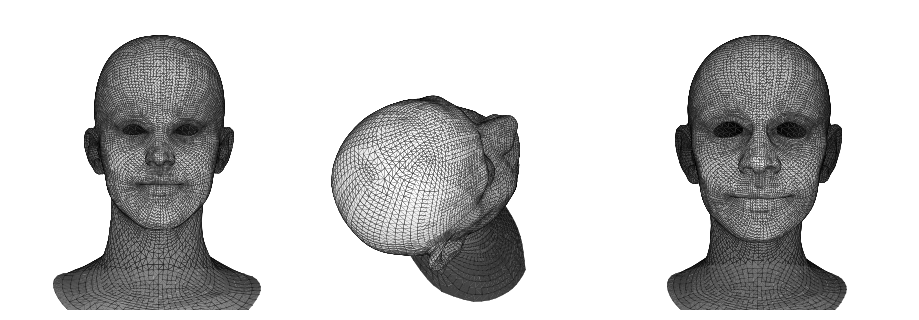

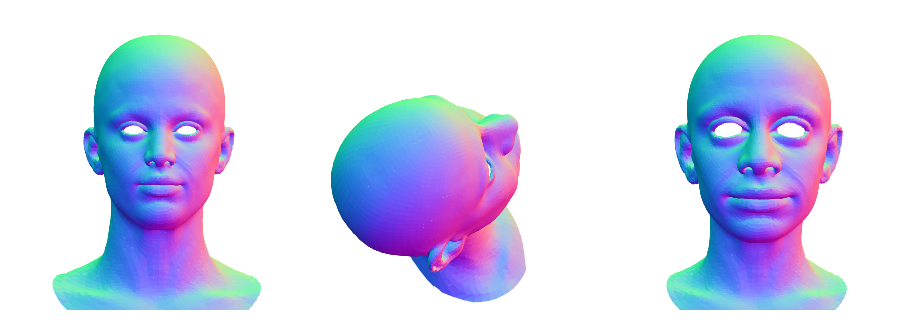

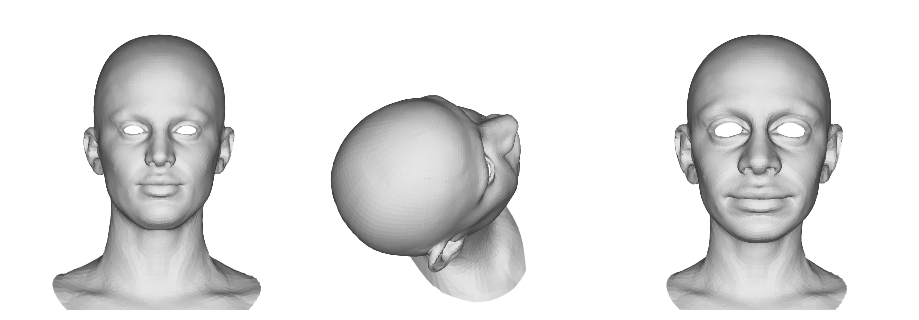

In [382]:
from matplotrender.src.matplotrender import *
# figure size
SIZE = 3
mesh_scale = 0.6
# mesh that you wanna render
FRAME=150
v_list=[ V, newV, np.matmul(newV,R.T) ]
v_list=[ v*mesh_scale for v in v_list]
f_list=[ F ]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)

plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

## Animation for the source mesh

In [426]:
# motions = np.load(r'_tmp\040.npy')
# print(motions.shape)

from utils.ict_face_model import ICT_face_model
ict = ICT_face_model()
blendshapes = ict.exp_basis[:,:11248]
BS = 26
BS1 = 26
BS2=5

# motions = np.load(r'_tmp\040.npy')
# displacements = motions - V[None]

displacements = blendshapes[BS1]+blendshapes[BS2]
print(displacements.shape, displacements.max())

(11248, 3) 0.083766006


## Get local coordinate system via TBN matrix

In [384]:
V_TBN = get_TBN_foreach_vertex(V, F)
newV_TBN = get_TBN_foreach_vertex(newV, F)

## Scale using BB

In [ ]:
# Vs = get_scale_foreach_vertex(V, F)
# newVs = get_scale_foreach_vertex(newV, F)
# newS = newVs/Vs
newS = get_scale_foreach_triangle(V, np.matmul(newV, R.T), F)
# newS = abs(newS)

    
newS = gaussian_filter(newS, 5, mode='nearest')

# Lap = igl.cotmatrix(V, F)
# newS = smooth(newS, Lap, loop=2, t=0.03)

newS = mesh_smooth(V, F, newS, tau=0.1)
# newS[:,0] = gaussian_filter1d(newS[:,0], 3,mode='nearest')
# newS[:,1] = gaussian_filter1d(newS[:,1], 3,mode='nearest')
# newS[:,2] = gaussian_filter1d(newS[:,2], 3,mode='nearest')

# max_std = newS.std(0)*3
# for i in range(3):
#     tmp = newS[:, i]
#     tmp[tmp > max_std[i]] = max_std[i]
#     newS[:, i] = tmp

# newS = newS @ np.eye(3)
newS = np.eye(3)[None,:,:] * newS[:,:,None]
print(newS.shape)

(11248, 3, 3)


## Animation with Motion Vectors

In [427]:
# MAT = newS * np.einsum('bcn, bnk->bck', newV_TBN.transpose(0,2,1), V_TBN)
MAT = np.einsum('bcn, bnk->bck', newV_TBN.transpose(0,2,1), V_TBN)
MAT = np.einsum('bcn, bnk->bck', newS, MAT)


new_displacements = np.einsum('bck, bk->bc', MAT, displacements)

## filtering...
new_displacements = mesh_smooth(V, F, new_displacements, tau=0.001)
# lap = igl.cotmatrix(V, F)
# new_displacements = smooth(displacements, lap, loop=3, t=0.01)
print(new_displacements.shape, new_displacements.min(), new_displacements.max())

(11248, 3) -0.4638299506065637 0.08092119922323907


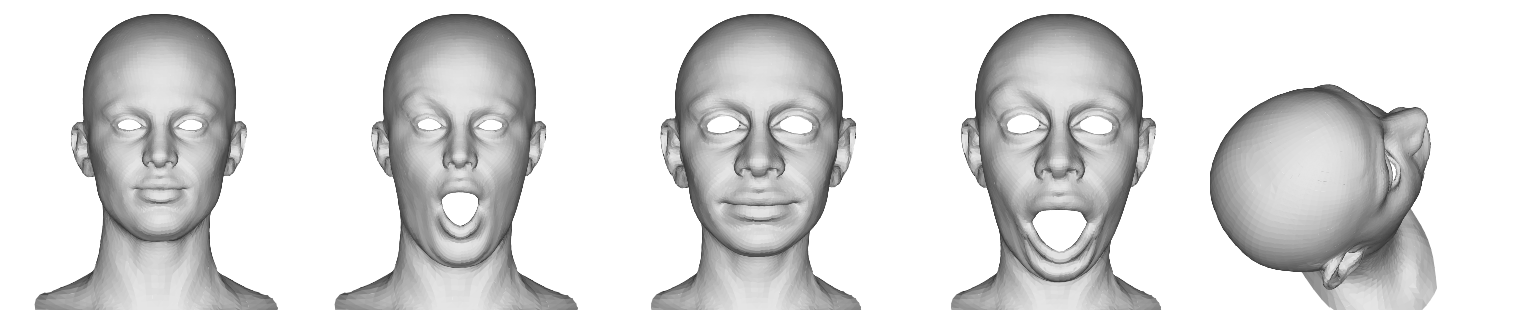

In [429]:
from matplotrender.src.matplotrender import *
# figure size
SIZE = 3
mesh_scale = .7
mesh_trans = np.array([0,0,0])
# mesh that you wanna render

v_list=[ V, displacements+V, np.matmul(newV, R.T), np.matmul(new_displacements+newV, R.T), new_displacements+newV]
v_list=[ v*mesh_scale+mesh_trans for v in v_list ]
f_list=[ F ]*len(v_list)

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)

# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

In [148]:
# import trimesh
# import matplotlib.pyplot as plt

# print(V.shape)
# pos = V[:6706]
# vec = new_displacements[0][:6706]
# # 또는 2D quiver plot
# plt.quiver(pos[:,0], pos[:,1], vec[:,0], vec[:,1])
# plt.axis('equal')
# plt.title('Gradient Field')
# plt.show()
